In [21]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from SALib.sample import latin
from SALib.analyze import pawn
from tqdm.notebook import tqdm

import mesa

from epstein_network_civil_violence.agent import Inhabitant, Police
from epstein_network_civil_violence.model import EpsteinNetworkCivilViolence
import numpy as np
import matplotlib.pyplot as plt

In [32]:
def compute_mean_outburst_size(model):
    if hasattr(model, 'outburst_sizes') and model.outburst_sizes:
        return np.mean(model.outburst_sizes)
    else:
        return 0

def compute_sd_outburst_size(model):
    if hasattr(model, 'outburst_sizes') and model.outburst_sizes:
        return np.std(model.outburst_sizes)
    else:
        return 0

# Define the problem for the PAWN sensitivity analysis
problem = {
    'num_vars': 5,
    'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant'],
    'bounds': [[1, 10],  # citizen_vision
               [1, 10],  # cop_vision
               [0.0, 1.0],  # legitimacy
               [0.0, 1.0],  # active_threshold
               [0.0, 1.0]]  # arrest_prob_constant
}

param_values = latin.sample(problem, 50)

# Run the model and collect results
results_mean = []
results_sd = []

for params in tqdm(param_values):
    citizen_vision, cop_vision, legitimacy, active_threshold, arrest_prob_constant = params
    model = EpsteinNetworkCivilViolence(
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.074,
        citizen_vision=int(citizen_vision),  
        cop_vision=int(cop_vision),
        legitimacy=legitimacy,
        max_jail_term=1000,
        active_threshold=active_threshold,
        arrest_prob_constant=arrest_prob_constant,
        movement=True,
        max_iters=300,
        alpha=0.1,
        jail_factor=1.1,
        legitimacy_impact=0.002,
        use_mean_field=True,
        legitimacy_width=0.1,
        cop_density_mode='constant',
        legitimacy_mode='constant'
    )
    
    # Initialize outburst sizes list
    model.outburst_sizes = []
    
    # Setup the DataCollector separately
    model.datacollector = DataCollector(
        agent_reporters={"Active": lambda a: getattr(a, 'active', False)},
        model_reporters={"Mean_Outburst_Size": compute_mean_outburst_size,
                         "SD_Outburst_Size": compute_sd_outburst_size}
    )
    
    for i in range(30):
        model.step()
    
    model.datacollector.collect(model)
    results_mean.append(model.datacollector.get_model_vars_dataframe()["Mean_Outburst_Size"].values[-1])
    results_sd.append(model.datacollector.get_model_vars_dataframe()["SD_Outburst_Size"].values[-1])

Y_mean = np.array(results_mean)
Y_sd = np.array(results_sd)

# PAWN sensitivity analysis
Si_mean = pawn.analyze(problem, param_values, Y_mean, S=10)
Si_sd = pawn.analyze(problem, param_values, Y_sd, S=10)

# Print the structure of the results
print("Si_mean:", Si_mean)
print("Si_sd:", Si_sd)


  0%|          | 0/50 [00:00<?, ?it/s]

Si_mean: {'minimum': array([0.06, 0.06, 0.06, 0.06, 0.06]), 'mean': array([0.09 , 0.098, 0.09 , 0.1  , 0.09 ]), 'median': array([0.06, 0.06, 0.06, 0.06, 0.06]), 'maximum': array([0.18, 0.36, 0.18, 0.34, 0.18]), 'CV': array([0.518783  , 0.92379349, 0.518783  , 0.87635609, 0.518783  ]), 'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant']}
Si_sd: {'minimum': array([0., 0., 0., 0., 0.]), 'mean': array([0., 0., 0., 0., 0.]), 'median': array([0., 0., 0., 0., 0.]), 'maximum': array([0., 0., 0., 0., 0.]), 'CV': array([nan, nan, nan, nan, nan]), 'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant']}


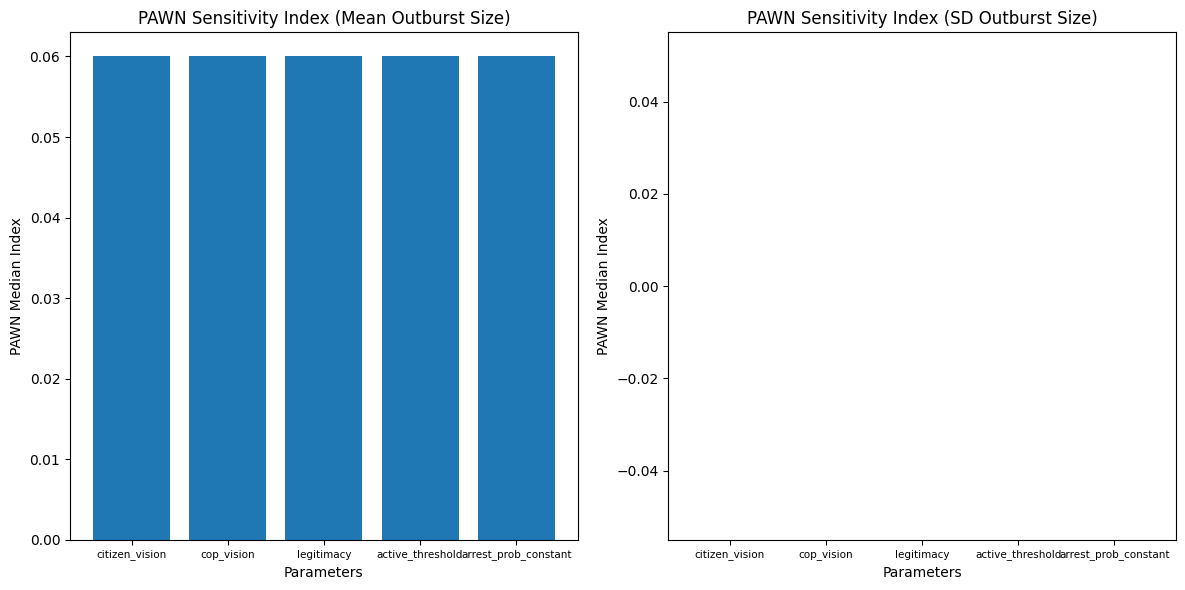

In [35]:

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Mean outburst size
ax[0].bar(problem['names'], Si_mean['median'])
ax[0].set_title('PAWN Sensitivity Index (Mean Outburst Size)')
ax[0].set_ylabel('PAWN Median Index')
ax[0].set_xlabel('Parameters')
ax[0].tick_params(axis='x', labelsize=7.5)  

# SD outburst size
ax[1].bar(problem['names'], Si_sd['median'])
ax[1].set_title('PAWN Sensitivity Index (SD Outburst Size)')
ax[1].set_ylabel('PAWN Median Index')
ax[1].set_xlabel('Parameters')
ax[1].tick_params(axis='x', labelsize=7.5)  

plt.tight_layout()
plt.show()


  0%|          | 0/2000 [00:00<?, ?it/s]

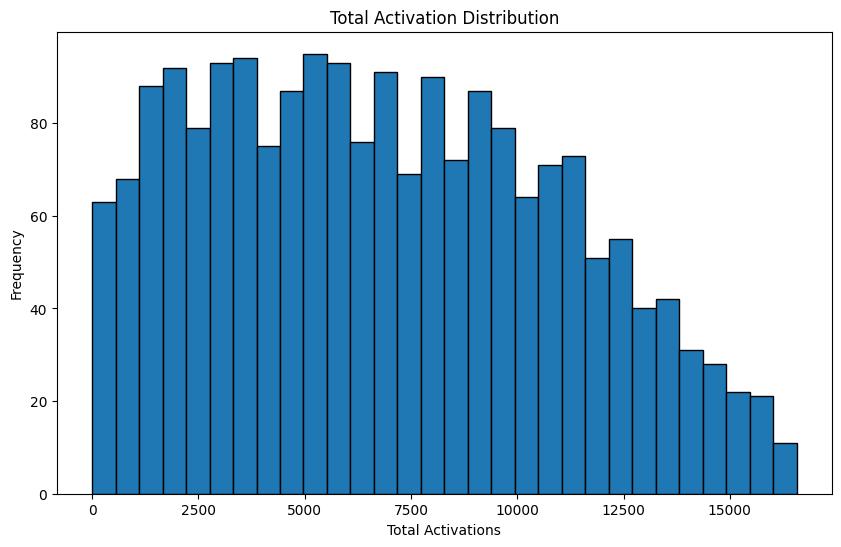

In [5]:
#this is still copied from my replacement assignment and not adapted to our code yet
# Redefining the civil violence model to plot activations as a histogram
class CivilViolenceModel(Model):
    def __init__(self, width, height, citizen_vision, cop_vision, legitimacy, active_threshold, arrest_prob_constant):
        self.num_agents = 200
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.citizen_vision = citizen_vision
        self.cop_vision = cop_vision
        self.legitimacy = legitimacy
        self.active_threshold = active_threshold
        self.arrest_prob_constant = arrest_prob_constant
        self.running = True
        self.total_activations = 0  # Track total activations
        self.datacollector = DataCollector(
            agent_reporters={"Active": lambda a: getattr(a, 'active', False)},
            model_reporters={"Mean_Outburst_Size": self.compute_mean_outburst_size,
                             "SD_Outburst_Size": self.compute_sd_outburst_size}
        )
        self.outburst_sizes = []

        for i in range(self.num_agents):
            if i < self.num_agents * 0.8:
                agent = Citizen(i, self)
            else:
                agent = Cop(i, self)
            self.schedule.add(agent)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def compute_mean_outburst_size(self):
        return np.mean(self.outburst_sizes) if self.outburst_sizes else 0

    def compute_sd_outburst_size(self):
        return np.std(self.outburst_sizes) if self.outburst_sizes else 0

class Citizen(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.active = False
        self.jail_time = 0

    def step(self):
        if not self.active and self.random.random() < self.model.legitimacy:
            self.active = True
            self.model.total_activations += 1  # Increment total activations
            self.model.outburst_sizes.append(1)
        elif self.active:
            if self.random.random() < self.model.arrest_prob_constant:
                self.active = False
                self.jail_time = 10
            else:
                self.model.outburst_sizes[-1] += 1

class Cop(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def step(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        active_citizens = [obj for obj in cellmates if isinstance(obj, Citizen) and obj.active]
        for citizen in active_citizens:
            if self.random.random() < self.model.arrest_prob_constant:
                citizen.active = False
                citizen.jail_time = 10

problem = {
    'num_vars': 5,
    'names': ['citizen_vision', 'cop_vision', 'legitimacy', 'active_threshold', 'arrest_prob_constant'],
    'bounds': [[1, 10],  # citizen_vision
               [1, 10],  # cop_vision
               [0.0, 1.0],  # legitimacy
               [0.0, 1.0],  # active_threshold
               [0.0, 1.0]]  # arrest_prob_constant
}

param_values = latin.sample(problem, 2000)

total_activations_list = []

for params in tqdm(param_values):
    model = CivilViolenceModel(20, 20, *params)
    for i in range(200):
        model.step()
    total_activations_list.append(model.total_activations)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(total_activations_list, bins=30, edgecolor='black')
plt.title('Total Activation Distribution')
plt.xlabel('Total Activations')
plt.ylabel('Frequency')
plt.show()


#### Discusssion
The results show that while there are fewer occurrences of very low and very high activation counts, the distribution of total activations in general appears to be skewed to the right. This means that while most runs result in a lower number of activations, there are a few runs with very high numbers of activations. The highest frequency of total activations occurs around the range of 4000 to 8000. This indicates that under most parameter combinations, the model tends to produce this range of total activations. The right-skewed distribution could mean that while moderate levels of unrest are typical, there are conditions under which the system can become unstable, leading to large-scale activations. In combination with the results of the sensitivity analysis, this could be due to combinations of high legitimacy, and particularly because of low arrest_prob_constant.